# 2.5 Inter-spike interval モデル
これまで紹介したモデルでは、入力に対する膜電位などの時間変化に基づき発火が起こるかどうか、ということを考えてきた。この節では、発火が生じるまでの過程を考慮せず、発火の時間間隔(**inter-spike interval, ISI**)の統計による現象論的モデルを考える。これを**Inter-spike interval (ISI)** モデルと呼ぶ。ISIモデルは**点過程(point process)** という統計的モデルに基づいており、各モデルにはISIが従う分布の名称がついている。この節では、使用頻度の高い **ポアソン過程 (Poisson process) モデル**、ポアソン過程モデルにおいて不応期を考慮した **死時間付きポアソン過程 (Poisson process with dead time, PPD) モデル**、皮質の定常発火においてポアソン過程モデルよりも当てはまりがよいとされる **ガンマ過程 (Gamma process) モデル**について説明する。

なお、SNNにおいて、ISIモデルは主に画像入力の際に**連続値からスパイク列へのエンコード**に用いられる。

## 2.5.1 ポアソン過程モデル
### 点過程とポアソン過程
時間に応じて変化する確率変数のことを**確率過程(stochastic process)** という。さらに確率過程の中で、連続時間軸上において離散的に生起する点事象の系列を**点過程(point process)** という。スパイクは離散的に起こるので、点過程を用いてモデル化ができるという話である。

ポアソン過程 (Poisson process)は点過程の1つである。ポアソン過程モデルはスパイクの発生をポアソン過程でモデル化したもので、このモデルによって生じるスパイクをポアソンスパイク(Poisson spike)と呼ぶ。ポアソン過程では、時刻$t$までに起こった点の数$N(t)$はポアソン分布に従う。すなわち、点が起こる確率が強度$\lambda$のポアソン分布に従う場合, 時刻$t$までに事象が$n$回起こる確率は$P[N(t)=n]=\dfrac{(\lambda t)^{n}}{n !} e^{-\lambda t}$となる。 

ポアソン過程において点が起こる回数がポアソン分布に従うことは、ポアソン過程という名称の由来となっている。これを定義とする場合もあれば、次の4条件を満たす点過程をポアソン過程とするという定義もある。

- 時刻0における初期の点の数は0 : $P[N(0)=0]=1$ 
- $[t, t+\Delta t)$に点が1つ生じる確率 : $P[N(t+\Delta t)-N(t)=1]=\lambda(t)\Delta t+o(\Delta t)$
- 微小時間$\Delta t$の間に点は2つ以上生じない : $P[N(t+\Delta t)-N(t)=2]=o(\Delta t)$
- 任意の時点$t_1 < t_2 < \cdots< t_n$に対して，増分 $N(t_2)-N(t_1), N(t_3)-N(t_2), \cdots, N(t_n)-N(t_{n−1})$は互いに独立である．

ただし, $o(\cdot)$はLandauの記号(Landauのsmall o)であり, $o(x)$は$x\to 0$のとき、$o(x)/x\to 0$となる微小な量を表す。ポアソン過程に従ってスパイクが生じるとする場合、条件2の強度関数$\lambda(t)$は**発火率**を意味する (また実装において有用)。条件3は不応期より小さいタイムステップにおいては、1つのタイムステップにおいて1つしかスパイクは生じないということを表す。条件4はスパイクは独立に発生する、ということを意味する。また、これらの条件から$N(t)$の分布は強度母数$\lambda(t)$のポアソン分布に従うことが示せる。

強度関数(点がスパイクの場合、発火率)が$\lambda(t)=\lambda$ (定数)となる場合は点の時間間隔(点がスパイクの場合、ISI)の確率変数$T$が強度母数$\lambda$の **指数分布**に従う。なお、指数分布の確率密度関数は確率変数を$T$とするとき、

$$
f(t;\lambda )=\left\{{\begin{array}{ll}\lambda e^{-\lambda t}&(t\geq 0)\\0&(t<0)\end{array}}\right.
$$

となる。このことは4条件とChapman-Kolmogorovの式により求められるが、ややこしいので, $P[N(t)=n]=\dfrac{(\lambda t)^{n}}{n !} e^{-\lambda t}$から導出できることを簡単に示す。指数分布の累積分布関数を$F(t; \lambda)$とすると、

$$
F(t; \lambda) = P(T<t)=1-P(T>t)=1-P(N(t)=0)=1-e^{-\lambda t}
$$

となる。よって

$$
f(t; \lambda)=\frac{dF(t; \lambda)}{dt}=\lambda e^{-\lambda t}
$$

が成り立つ。

### 定常ポアソン過程
ここからポアソン過程によるスパイクのシミュレーションを実装する。実装方法にはISIが指数分布に従うことを利用したものと、ポアソン過程の条件2を利用したものの2通りがある。実装は後者が楽で計算量も少ないが、後のガンマ過程のために前者の実装を先に行う。

ISIが指数分布に従うことを利用してポアソン過程モデルの実装を行う。SNNのシミュレーションにおいてスパイク列$S$はタイムステップごとに発火しているかの$\{0,1\}$配列で保持しておくと楽に扱うことができる (もちろん発火時刻で記録しておく方がメモリを節約できるが、計算量が多くなる)。手順としては、まずISIを指数分布に従う乱数とする。次にISIを累積することで発火時刻を得る。最後に発火時間を整数値に丸めてindexとすることで$\{0, 1\}$のスパイク列が得られる。ISIの取得には`Random.randexp()`を用いる。この関数は scale 1の指数分布に従う乱数を返す。このscaleは指数分布の確率密度関数を$f(t; \frac{1}{\beta}) = \frac{1}{\beta} e^{-t/\beta}$とした際の$\beta = 1/\lambda$である(この時、平均は$\beta$となる)。よって発火率を`fr`(1/s), 単位時間を`dt`(s)としたときのISIは `isi = 1/(fr*dt) * randexp()`として得ることができる。

In [3]:
using Random

In [7]:
Random.seed!(0)

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps
n_neurons = 10 # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)
isi = 1/(fr*dt*1e-3) * randexp(Int32(nt*1.5/fr), n_neurons)
spike_time = cumsum(isi, dims=1) # ISIを累積

50×10 Array{Float64,2}:
  26.0798     18.7021     3.34424    …   22.7374    88.2338    59.7583
  34.674      64.8662     6.64063        58.2991    56.5209    28.6503
  11.0091     50.6217    79.9787         43.7936    40.3868    49.6938
   4.91605    20.6885    37.8551         28.0283   148.288     42.6451
  17.4736     25.3754    88.366          18.6542    46.6095    95.7841
  27.7003     47.3594    59.8142     …   26.8355    17.4899    14.6036
  12.2634     34.4674    15.1989         73.6821    17.7546    17.4035
   0.977488    0.95514   19.2118         22.1991    31.0191    15.891
  43.0434     60.0962    17.7433          6.99543    1.73574   33.4196
  16.1031     16.9899    58.8577          2.43394    1.58002   56.0889
  38.624      87.2125    15.61       …    4.0015     1.97198   30.9447
  62.7883     13.4964    43.8158         28.5431    85.9748    23.2988
  60.1639    129.636      0.0110156       4.31969   14.9491    15.8819
   ⋮                                 ⋱                

In [9]:
using Plots

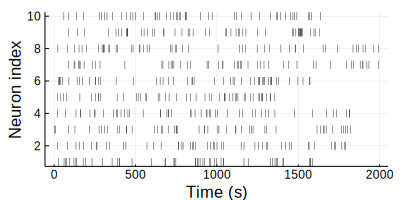

In [34]:
p = plot(xlabel ="Time (s)", ylabel="Neuron index", legend=false, size=(400, 200))
for i=1:n_neurons
    scatter!(p, spike_time[:, i], i*ones(Int32(nt*1.5/fr)), shape=:vline, color="black")
end
display(p)

scatterのmarkerに関してはhttp://julia.cookbook.tips/doku.php?id=plotting

In [ ]:
spike_time[spike_time > nt - 1] = 0 # ntを超える場合を0に
spike_time = spike_time.astype(np.int32) # float to int
spikes = np.zeros((nt, n_neurons)) # スパイク記録変数

for i =1:n_neurons    
    spikes[spike_time[:, i], i] = 1
spikes[1] = 0 # (spike_time=0)の発火を削除
print("Num. of spikes:", sum(spikes))
print("Firing rate:", sum(spikes)/(n_neurons*T))
# 描画
t = np.arange(nt)*dt
plt.figure(figsize=(5, 4))
for i in range(n_neurons):    
    plt.plot(t, spikes[:, i]*(i+1), 'ko', markersize=2)
plt.xlabel('Time (s)'); plt.ylabel('Neuron index') 
plt.xlim(0, T); plt.ylim(0.5, n_neurons+0.5)
plt.show()

In [ ]:
function rasterplot()
    # input spike -> #neuron, time -> scatter

結果は図のようになります。

次に2番目のポアソン過程モデルの実装を行います。こちらは$\lambda$を発火率とした場合, 区間$[t, t+\Delta t]$の間にポアソンスパイクが発生する確率は$\lambda \Delta t$となることを利用します。これはポアソン過程の条件ですが、ポアソン分布から導けることを簡単に示しておきます。事象が起こる確率が強度$\lambda$のポアソン分布に従う場合, 時刻$t$までに事象が$n$回起こる確率は$P[N(t)=n]=\dfrac{(\lambda t)^{n}}{n !} e^{-\lambda t}$となります. よって, 微小時間$\Delta t$において事象が$1$回起こる確率は
$$P[N(\Delta t)=1]=\dfrac{\lambda \Delta t}{1 !} e^{-\lambda \Delta t}\simeq \lambda \Delta t+o(\Delta t)$$
となります. ただし, $e^{-\lambda \Delta t}$についてはマクローリン展開による近似を行っています. このことから, 一様分布$U(0,1)$に従う乱数$\xi$を取得し, $\xi<\lambda dt$なら発火$(y=1)$, それ以外では$(y=0)$となるようにすればポアソンスパイクを実装できます.


In [ ]:
np.random.seed(seed=0)
dt = 1e-3; T = 1; nt = round(T/dt) # シミュレーション時間
n_neurons = 10 # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

# スパイク記録変数
spikes = np.where(np.random.rand(nt, n_neurons) < fr*dt, 1, 0)

print("Num. of spikes:", np.sum(spikes))
print("Firing rate:", np.sum(spikes)/(n_neurons*T))
# 描画
t = np.arange(nt)*dt
plt.figure(figsize=(5, 4))
for i in range(n_neurons):    
    plt.plot(t, spikes[:, i]*(i+1), 'ko', markersize=2)
plt.xlabel('Time (s)'); plt.ylabel('Neuron index') 
plt.xlim(0, T); plt.ylim(0.5, n_neurons+0.5)
plt.show()

結果は図\ref{fig:poisson_process}のようになります。
\caption{ポアソン過程モデルによる10個のニューロンのスパイクの1秒間のシミュレーション。(左)ISIの累積により発火時刻を求める手法。(右)$\Delta t$間の発火確率が$\lambda\Delta t$であることを利用する方法。結果は同一ですが、実行速度は右の方が速いです。}

なお、ここでは全時間における発火をまとめて計算していますが、タイムステップごとに発火の有無を計算することもできます。前者は発火情報を保持するためのメモリが必要ですが、計算時間は短くて済みます。後者はメモリの節約になりますが、計算時間は長くなります。そのため、これら2つの方法はメモリと計算時間のトレードオフとなります。また、他には発火情報を疎行列(sparse matrix)の形式で保持しておくとメモリの節約になると思われます。

### 非定常ポアソン過程
これまでの実装は発火率$\lambda$が一定であるとする、定常ポアソン過程 (homogeneous poisson process)であったが、ここからは発火率$\lambda(t)$が時間変化するとする**非定常ポアソン過程** (inhomogeneous poisson process)について考える。とはいえ、定常ポアソン過程における発火率を、時間についての関数で置き換えるだけで実装できる。以下は$\lambda(t)=\sin^2(\alpha t)$(ただし$\alpha$は定数)とした場合の実装である。

In [ ]:
np.random.seed(seed=0)
dt = 1e-3; T = 1; nt = round(T/dt) # シミュレーション時間
n_neuron = 10 # ニューロンの数
t = np.arange(nt)*dt

# ポアソンスパイクの発火率(Hz)
fr = np.expand_dims(30*np.sin(10*t)**2, 1)

# スパイク記録変数
spikes = np.where(np.random.rand(nt, n_neuron) < fr*dt, 1, 0)

print("Num. of spikes:", np.sum(spikes))
# 描画
plt.figure(figsize=(5, 4))
plt.subplot(2,1,1)
plt.plot(t, fr[:, 0], color="k")
plt.ylabel('Firing rate (Hz)') 
plt.xlim(0, T)

plt.subplot(2,1,2)
for i in range(n_neuron):    
    plt.plot(t, spikes[:, i]*(i+1), 'ko', markersize=2,
             rasterized=True)
plt.xlabel('Time (s)'); plt.ylabel('Neuron index') 
plt.xlim(0, T); plt.ylim(0.5, n_neuron+0.5)
plt.show()

結果は図\ref{fig:ipp}のようになります。
\begin{figure}[htbp]
 \begin{minipage}{0.5\hsize}
  \begin{center}
   \includegraphics[width=65mm]{figs/inhomogenous_poisson_process.pdf}
   \caption{非定常ポアソン過程による10個のニューロンのスパイクの1秒間のシミュレーション。(上)発火率$\lambda(t)$の時間変化, (下)ラスタープロット。}

## 2.5.2 死時間付きポアソン過程モデル (Poisson process with dead time, PPD)
ポアソン過程は簡易的で有用ですが、不応期を考慮していない。そのため、時には生理的範疇を超えたバースト発火が起こる場合もある[^burst]。そこで、ポアソン過程において不応期のようなイベントの生起が起こらない **死時間(dead time)** [^deadtime]を考慮した**死時間付きポアソン過程 (Poisson process with dead time, PPD)} (またはdead time modified Poisson process)というモデルを導入する。

実装においてはLIFニューロンの時と同じような不応期の処理をする。つまり、現在が不応期かどうかを判断し、不応期なら発火を許可しないようにする。

[^burst]: 複数のニューロンからの発火の重ね合わせ(superposition)であると考えることもできる。
[^deadtime]: 例えば、ガイガー・カウンター(Geiger counter)などの放射線の検出器には放射線の到達を機器の物理的特性として検出できない時間(つまり死時間)がある。そのため放射線の到達数がポアソン分布に従うとした場合、放射線測定装置のモデルとしてPPDが用いられる。

In [ ]:
np.random.seed(seed=0)
dt = 1e-3; T = 1; nt = round(T/dt) # シミュレーション時間
n_neurons = 10 # ニューロンの数
tref = 5e-3 # 不応期 (s)
fr = 30 # ポアソンスパイクの発火率(Hz)
spikes = np.zeros((nt, n_neurons)) #スパイク記録変数
tlast = np.zeros(n_neurons) # 発火時刻の記録変数
for i in range(nt):
    s = np.where(np.random.rand(n_neurons) < fr*dt, 1, 0)
    spikes[i] = ((dt*i) > (tlast + tref))*s
    tlast = tlast*(1-s) + dt*i*s # 発火時刻の更新

print("Num. of spikes:", np.sum(spikes))
print("Firing rate:", np.sum(spikes)/(n_neurons*T))
# 描画
t = np.arange(nt)*dt
plt.figure(figsize=(5, 4))
for i in range(n_neurons):    
    plt.plot(t, spikes[:, i]*(i+1), 'ko', markersize=2)
plt.xlabel('Time (s)'); plt.ylabel('Neuron index') 
plt.xlim(0, T); plt.ylim(0.5, n_neurons+0.5)
plt.show()

## 2.5.3 ガンマ過程モデル
ガンマ過程(gamma process)は点の時間間隔がガンマ分布に従うとするモデルです。ガンマ過程はポアソン過程よりも皮質における定常発火への当てはまりが良いとされています(Shinomoto, et al., 2003; Maimon,\& Assad,2009).

時間間隔の確率変数を$T$とした場合、ガンマ分布の確率密度関数は
\begin{equation}
f(t;k,\theta) =  t^{k-1}\frac{e^{-t/\theta}}{\theta^k\Gamma(k)}
\end{equation}
と表されます。ただし、$t > 0$であり、 2つの母数は$k, \theta > 0$です。また、$\Gamma (\cdot)$はガンマ関数であり、
\begin{equation}
\Gamma (k)=\int _{0}^{\infty }x^{k-1}e^{-x}\,dx
\end{equation}
と定義されます。ガンマ分布の平均は$k\theta$ですが、発火率はISIの平均の逆数なので、$\lambda=1/k\theta$となります。また、$k=1$のとき、ガンマ分布は指数分布となります。さらに$k$が正整数のとき、ガンマ分布はアーラン分布となります。\par
ガンマ過程モデルの実装はポアソン過程モデルのISIを累積する手法と同様に書くことができ、\texttt{numpy.random.exponential()}を\texttt{numpy.random.gamma()}に置き換えるだけです(もちろん多少の修正は必要とします)。また、ガンマ分布の描画にガンマ関数を用いるので、\texttt{import scipy.special as sps}によりガンマ関数の関数\texttt{sps.gamma()}を使用できるようにします

In [ ]:
import scipy.special as sps
np.random.seed(seed=0)
dt = 1e-3; T = 1; nt = round(T/dt) # シミュレーション時間
n_neurons = 10 # ニューロンの数
fr = 30 # ガンマスパイクの発火率(Hz)
k = 12 # k=1のときはポアソン過程に一致
theta = 1/(k*(fr*dt)) # fr = 1/(k*theta)
isi = np.random.gamma(shape=k, scale=theta,
                      size=(round(nt*1.5/fr), n_neurons))
spike_time = np.cumsum(isi, axis=0) # ISIを累積
spike_time[spike_time > nt - 1] = -1 # ntを超える場合を0に
spike_time = spike_time.astype(np.int32) # float to int
spikes = np.zeros((nt, n_neurons)) # スパイク記録変数
for i in range(n_neurons):    
    spikes[spike_time[:, i], i] = 1
spikes[0] = 0 # (spike_time=0)の発火を削除
print("Num. of spikes:", np.sum(spikes))
print("Firing rate:", np.sum(spikes)/(n_neurons*T))

# 描画
plt.figure(figsize=(5, 5))
t = np.arange(nt)*dt
plt.subplot(2,1,1)
count, bins, ignored = plt.hist(isi.flatten(),
                                50, density=True,
                                color="gray", alpha=0.5)
y = bins**(k-1)*(np.exp(-bins/theta) / (sps.gamma(k)*theta**k))
plt.plot(bins, y, linewidth=2, color="k")
plt.title('k='+str(k)) 
plt.xlabel('ISI (ms)') 
plt.ylabel('Probability density') 

plt.subplot(2,1,2)
for i in range(n_neurons):    
    plt.plot(t, spikes[:, i]*(i+1), 'ko', markersize=2)
plt.xlabel('Time (s)'); plt.ylabel('Neuron index') 
plt.xlim(0, T); plt.ylim(0.5, n_neurons+0.5)
plt.show()

ガンマ過程モデルによる10個のニューロンのスパイクの1秒間のシミュレーション。上段はISIの分布(横軸の単位がmsであることに注意)。下段はラスタープロット。左の$k=1$の場合はポアソン過程モデルと同じです。右は$k=12$とした場合です。}
\label{fig:gamma_process}
\end{figure}
なお、前述したようにガンマ過程モデルの方がポアソン過程モデルよりも皮質ニューロンのモデルとしては優れていますが、入力画像のエンコーディングをガンマ過程モデルにすることでSNNの認識精度が向上するかどうかはまだ十分に研究されていません。また、(Deger, et al., 2012)ではPPDやガンマ過程の重ね合わせによるスパイク列を生成するアルゴリズムを考案しています。